## Initialization

In [2]:
%matplotlib notebook

import pylab as plt
import numpy as np
import seaborn as sns; sns.set()

import keras
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.optimizers import Adam

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(60000, 784) / 255
x_test = x_test.reshape(10000, 784) / 255

## PCA

In [3]:
mu = x_train.mean(axis=0)
U,s,V = np.linalg.svd(x_train - mu, full_matrices=False)
Zpca = np.dot(x_train - mu, V.transpose())

Rpca = np.dot(Zpca[:,:2], V[:2,:]) + mu    # reconstruction
err = np.sum((x_train-Rpca)**2)/Rpca.shape[0]/Rpca.shape[1]
print('PCA reconstruction error with 2 PCs: ' + str(round(err,3)))

PCA reconstruction error with 2 PCs: 0.056


## Training the autoencoder

In [16]:
m = Sequential()
m.add(Dense(512,  activation='elu', input_shape=(784,)))
m.add(Dense(128,  activation='elu'))
m.add(Dense(50,    activation='linear', name="bottleneck"))
m.add(Dense(128,  activation='elu'))
m.add(Dense(512,  activation='elu'))
m.add(Dense(784,  activation='sigmoid'))
m.compile(loss='mean_squared_error', optimizer = Adam())
history = m.fit(x_train, x_train, batch_size=128, epochs=5, verbose=1, 
                validation_data=(x_test, x_test))

encoder = Model(m.input, m.get_layer('bottleneck').output)
Zenc = encoder.predict(x_train)  # bottleneck representation
Renc = m.predict(x_train)        # reconstruction

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 99us/step - loss: 0.0261 - val_loss: 0.0117
Epoch 2/5
60000/60000 [==============================] - 6s 97us/step - loss: 0.0101 - val_loss: 0.0083
Epoch 3/5
60000/60000 [==============================] - 5s 84us/step - loss: 0.0077 - val_loss: 0.0069
Epoch 4/5
60000/60000 [==============================] - 5s 88us/step - loss: 0.0065 - val_loss: 0.0059
Epoch 5/5
60000/60000 [==============================] - 5s 84us/step - loss: 0.0057 - val_loss: 0.0054


so you can already see that we surpassed PCA loss after only two training epochs.

(By the way, it is instructive to change all activation functions to `activation='linear'` and to observe how the loss converges precisely to the PCA loss. That is because linear autoencoder is equivalent to PCA.)

## Plotting PCA projection side-by-side with the bottleneck representation

<IPython.core.display.Javascript object>


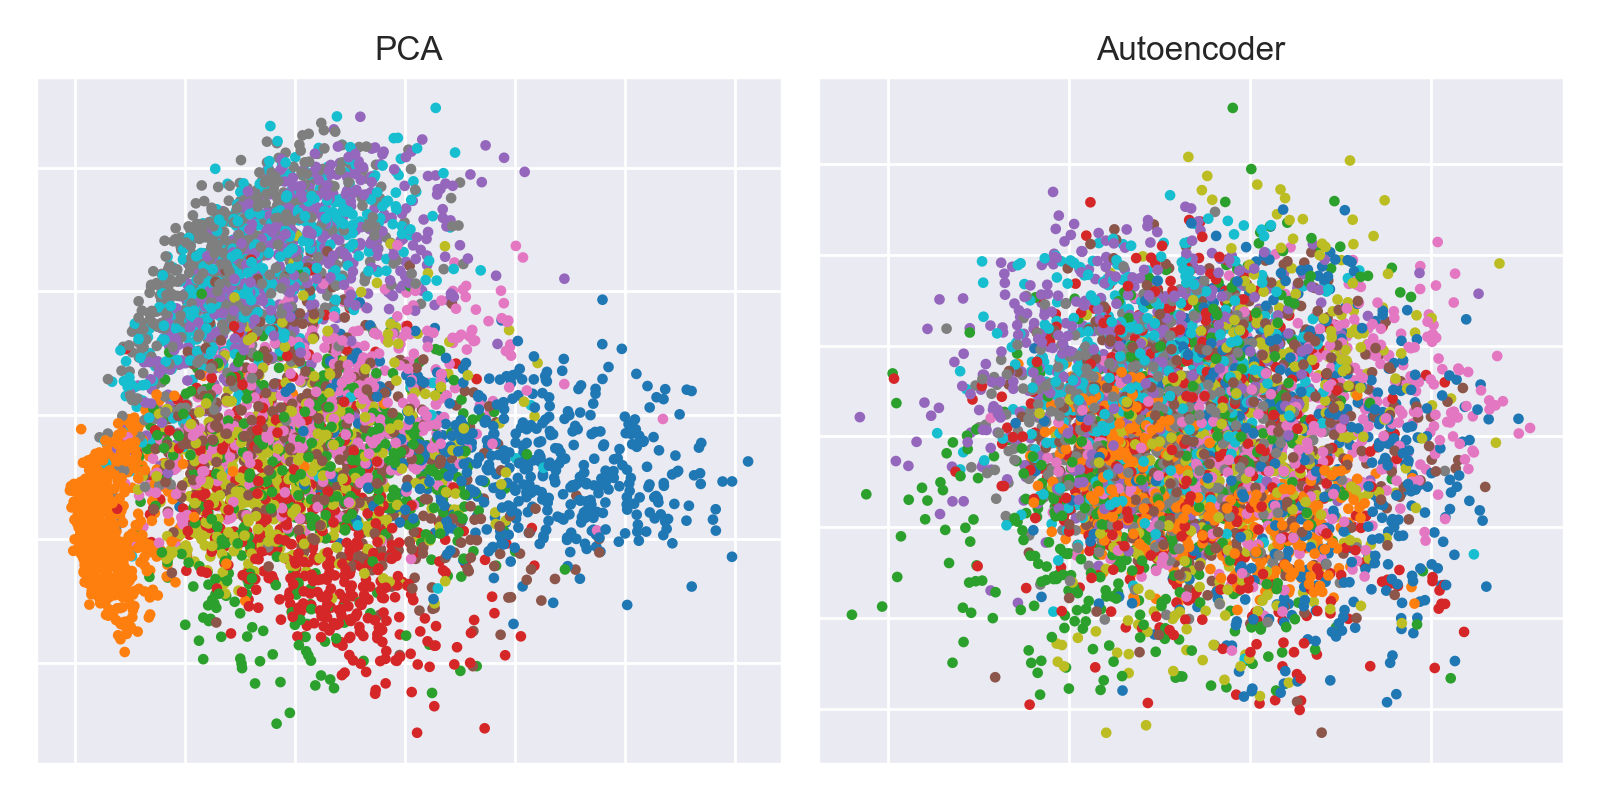

In [17]:
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.title('PCA')
plt.scatter(Zpca[:5000,0], Zpca[:5000,1], c=y_train[:5000], s=8, cmap='tab10')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

plt.subplot(122)
plt.title('Autoencoder')
plt.scatter(Zenc[:5000,0], Zenc[:5000,1], c=y_train[:5000], s=8, cmap='tab10')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])

plt.tight_layout()

In [18]:
print(Zenc.shape)
print(type(Zenc))

(60000, 50)
<class 'numpy.ndarray'>


In [19]:
saveData = np.hstack((y_train.reshape(-1,1), Zenc))
saveData

array([[ 5.        ,  5.698556  , -0.29684743, ..., -4.838268  ,
        -1.3299408 , -0.42611977],
       [ 0.        ,  7.1839385 ,  2.2052698 , ..., -5.138369  ,
        -3.8175657 ,  4.178676  ],
       [ 4.        ,  2.8508053 ,  1.3353773 , ...,  1.9186997 ,
        -2.756053  ,  1.5281638 ],
       ...,
       [ 5.        ,  5.4132895 ,  2.7211497 , ..., -4.2898016 ,
        -0.13386253, -1.0125315 ],
       [ 6.        ,  6.0614967 ,  3.5200763 , ..., -2.3158867 ,
        -2.573434  ,  4.271164  ],
       [ 8.        ,  4.1182923 ,  1.2423606 , ..., -1.636931  ,
         1.8988985 ,  1.2438536 ]], dtype=float32)

In [20]:
fin = "/Users/yyq/Library/Mobile Documents/com~apple~CloudDocs/ipad_mac/github/[Yuan2015] BitPhylogeny/我的 test/mnist"
np.savetxt(fin + "/mnistFeaturesAE50D1.csv", saveData, delimiter=",")

## Reconstructions

And now let's look at the reconstructions (first row - original images, second row - PCA, third row - autoencoder):

In [ ]:
plt.figure(figsize=(9,3))
toPlot = (x_train, Rpca, Renc)
for i in range(10):
    for j in range(3):
        ax = plt.subplot(3, 10, 10*j+i+1)
        plt.imshow(toPlot[j][i,:].reshape(28,28), interpolation="nearest", 
                   vmin=0, vmax=1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.tight_layout()